## Outline

1. Why do we use batching
2. Batching for sequence models
3. Padding and packing in PyTorch
4. Training with batched dataset
5. Comparison of performance with batching and on GPU

## Setting Environment

In [1]:
#load the packages

from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
plt.style.use("seaborn")

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.display import clear_output

#instantiates the device to be used as GPU/CPU 
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
device_gpu

device(type='cpu')

## Pre-Processing

In [4]:
#load the data

languages = []
data = []
X = []
y = []

with open("name2lang.txt", 'r') as f:
    for line in f:
        line = line.split(",")
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

#number of languages
n_languages = len(languages)
print("Total number of languages present: ", n_languages)

Total number of languages present:  18


In [5]:
#print the languages
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [6]:
print(data[:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


## Train Test Split

In [7]:
#split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123, stratify = y)

In [8]:
#count
print("The number of observations in the training data: ", len(X_train))
print("The number of observations in the test data: ", len(X_test))

The number of observations in the training data:  16040
The number of observations in the test data:  4010


## Encoding Names and Languages

In [9]:
#get all the letters used for encoding
all_letters = string.ascii_letters + ".,;"
#count the number of letters
n_letters = len(all_letters)

print(n_letters)

55


In [10]:
#function to create representation of the name
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters) #Create a zeros tensor
    #iterate through all the characters in the name
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1 #Assign a value for each pos value
    return rep

In [11]:
#function to create vec representation of the language
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype = torch.long)

In [12]:
#example of name representation
name_rep("kumar")

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0.]],

        [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [13]:
#example of language representation
lang_rep("Portuguese")

tensor([0])

## Visualization 
- Basic Visualization of labels

In [14]:
count = {}
for l in languages: 
    count[l] = 0
for d in data:
    count[d[1]] += 1

In [15]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


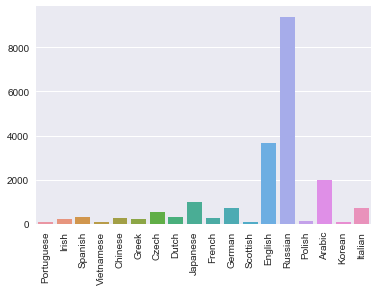

In [16]:
#plot the distribution of labels

plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

## Basic RNN Network and Interference

In [17]:
#create simple rnn network 
class RNN_net(nn.Module):
    #Create a constructor
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size 
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h20 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    #create a forward pass function
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h20(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, batch_size = 1):
        #function to init the hidden layers
        return torch.zeros(1, batch_size, self.hidden_size)

In [18]:
#function to run interference
def infer(net, name, device = "cpu"):
    name_ohe = name_rep(name).to(device)

    #get the output
    output, hidden = net(name_ohe)

    if type(hidden) is tuple: #for lSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)

    return output

In [19]:
#create hidden layers
n_hidden = 128 #hidden layers count

#initialize the network
net = RNN_net(input_size=n_letters, hidden_size=n_hidden, output_size=n_languages)

In [20]:
#check for inference
infer(net, "kumar", device_gpu)

tensor([[-2.9286, -2.8872, -3.0193, -2.9025, -2.8658, -2.8303, -2.8928, -2.8316,
         -2.9389, -2.8833, -2.8648, -2.9344, -3.0031, -2.8302, -2.8124, -2.9345,
         -2.7542, -2.9516]], grad_fn=<LogSoftmaxBackward>)

## Evaluate Model
- Check the model working before training

In [21]:
def dataloader(npoints, X_, y_):
    """Function to load the data"""
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_] #subset the data
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    
    return to_ret

In [22]:
#loading dataloader
dataloader(2, X_train, y_train)

[('Jitluhin',
  'Russian',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [23]:
#create an evaluation function 

def eval(net, n_points, topk, X_, y_, device = "cpu"):
    "Evaluation function"

    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0

    #iterate
    for name, language, name_ohe, lang_rep in data_:

        #get the output
        output = infer(net, name, device)
        val, indices = output.topk(topk) #get the top k values
        indices = indices.to(device) #convert to devices
        
        if lang_rep in indices:
            correct += 1

    accuracy = correct/n_points
    return accuracy

In [24]:
#test the evaluation function
eval(net, 1000, 1, X_test, y_test)

0.012

## Batching in Pytorch

In [25]:
#create a batched name rep

def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [26]:
#function to print the output

def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [27]:
#example of batching

out_ = batched_name_rep(['Shyam', 'Ram'], 5)
print_char(out_)

S
R
h
a
y
m
a
<pad>
m
<pad>


In [28]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep

In [29]:
#create dataloader
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [30]:
batched_dataloader(2, X_train, y_train, True)

torch.Size([7, 2, 55]) torch.Size([12, 55])
--
['Ikeda', 'Artenov']
I
A
k
r
e
t
d
e
a
n
<pad>
o
<pad>
v
--
A
I
r
k
t
e
e
d
n
a
o
v
Lang Rep tensor([ 8, 13])
Batch sizes tensor([2, 2, 2, 2, 2, 1, 1])


(PackedSequence(data=tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.,

## Training Setup

In [31]:
#basic train function

def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [32]:
#define parameters

net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [34]:
#parameters for batch training

net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [39]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [33]:
%%time 
#time for normal training
train(net, opt, criterion, 256)

Wall time: 2.45 s


tensor(2.9113, grad_fn=<DivBackward0>)

In [40]:
%%time 
#batch training
train_batch(net, opt, criterion, 256)

Wall time: 158 ms


tensor(2.8875, grad_fn=<NllLossBackward>)

## Full training setup

In [41]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1 Accuracy:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2 Accuracy:', eval(net, len(X_test), 2, X_test, y_test, device))
                      

## RNN Cell

Iteration 4999 Loss 0.4580404758453369


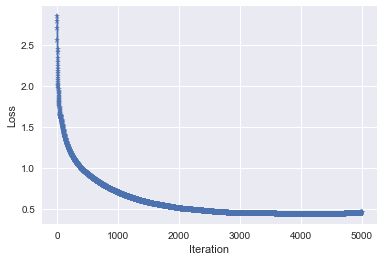




Top-1 Accuracy: 0.7366583541147133 Top-2 Accuracy: 0.85785536159601
Wall time: 18min 9s


In [42]:
%%time

#training RNN using batch technique
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=500) # CPU Training example

## LSTM cell

In [43]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.lstm_cell(input, hidden)
        output = self.h2o(hidden[0].view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

Iteration 7999 Loss 0.2452019453048706


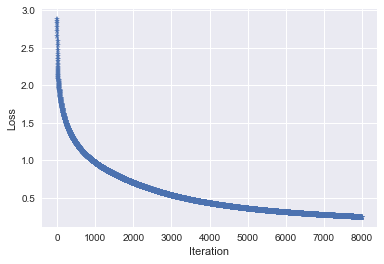




Top-1 Accuracy: 0.7902743142144638 Top-2 Accuracy: 0.8902743142144638


In [44]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)

## GRU Cell

In [45]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.gru_cell(input, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

In [ ]:
n_hidden = 128
net = GRU_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)